## Creates binarized Seurat objects, and merges them and finds Top Features (min.cutoff=20)

In [1]:
# Input info
cellr_in <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/DUPI_april08_2021_Croker/MTblacklist/"
samples <- "rxn1,rxn2,rxn3,rxn4"
sample_names <- "preA,preB,postA,postB"

# Saving
outdir <- "/data/isshamie/mito_lineage/output/annotation/DUPI_april08_2021/MTblacklist_mtasnucl/mergedSamples" #"/data2/mito_lineage/Analysis/annotation/output/data/"

# Parameters
nTop = 25000
cores = 36

In [2]:
library(repr)
options(repr.plot.width=12, repr.plot.height=12)

Warning message:
“package ‘repr’ was built under R version 4.0.3”


In [3]:
# # Input info
# cellr_in <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/jan21_2021/MTblacklist"
# samples <- "J2,P2"
# sample_names <- "Flt3l,Control"

# # Saving
# outdir <- "/data/isshamie/mito_lineage/output/annotation/cd34norm/MTblacklist/mergedSamples" #"/data2/mito_lineage/Analysis/annotation/output/data/"

# # Parameters
# nTop = 25000
# assay="RNA"

# cores = 36

In [4]:
samples <- unlist(strsplit(samples, ",")[[1]])
sample_names <- unlist(strsplit(sample_names, ","))

samples

[1] "rxn1" "rxn2" "rxn3" "rxn4"

In [5]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library(future)
plan()

plan("multiprocess", workers = cores)
options(future.globals.maxSize = 8000 * 1024^2)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
#plan("multiprocess", workers = workers)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The follow

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


## Merge all peaks

In [6]:
read.peaks <- function(exp, cellr_in){
    print('here')
    print(file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"))
    peaks <- read.table(
      file = file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"),
      col.names = c("chr", "start", "end")
    )
    # convert to genomic ranges
    gr <- makeGRangesFromDataFrame(peaks)
    return(gr)
}


gr.full <- c(sapply(samples, read.peaks, cellr_in=cellr_in, USE.NAMES=F))

gr.full.c <- gr.full[[1]]
if (length(gr.full)>1){
    for (i in 2:length(gr.full)){
      gr.full.c <- c(gr.full.c, gr.full[[i]])
    }
}
combined.peaks <- reduce(x = c(gr.full.c))

# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
combined.peaks

[1] "here"
[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/DUPI_april08_2021_Croker/MTblacklist_mtasnucl//rxn1/outs/filtered_peak_bc_matrix/peaks.bed"
[1] "here"
[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/DUPI_april08_2021_Croker/MTblacklist_mtasnucl//rxn2/outs/filtered_peak_bc_matrix/peaks.bed"
[1] "here"
[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/DUPI_april08_2021_Croker/MTblacklist_mtasnucl//rxn3/outs/filtered_peak_bc_matrix/peaks.bed"
[1] "here"
[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/DUPI_april08_2021_Croker/MTblacklist_mtasnucl//rxn4/outs/filtered_peak_bc_matrix/peaks.bed"


GRanges object with 49634 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1       10169-10267      *
      [2]     chr1     191337-191519      *
      [3]     chr1     268046-268142      *
      [4]     chr1     778355-779233      *
      [5]     chr1     827080-827940      *
      ...      ...               ...    ...
  [49630]     chrY 56863163-56863474      *
  [49631]     chrY 56865579-56866679      *
  [49632]     chrY 56868819-56871669      *
  [49633]     chrY 56872060-56874599      *
  [49634]     chrY 56879752-56880373      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

## Create fragment objects

In [7]:
# create_frag <- function(exp, cellr_in){
#     barcode_path <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")    
#     barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)
#     frag_file <- file.path(cellr_in, exp, "outs", "fragments.tsv.gz")
#     # quantify multiome peaks in the scATAC-seq dataset
#     frags.curr <- CreateFragmentObject(path = frag_file,cells= barcodes[["X1"]])
#     barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=exp)
#     ## Quantify peaks
#     curr.counts <- FeatureMatrix(
#       fragments = frags.curr,
#       features = combined.peaks,
#       cells = rownames(barcodes),
#       process_n = 8
#     )
    
#     ## Create the objects
#     curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr)
#     curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=exp, meta.data=barcodes)
#     curr <- BinarizeCounts(curr)
#     return(curr)
# }
allSE = c()#[]

samples_df <- cbind(sample_names, samples)
for (row in 1:nrow(samples_df)){
    exp <- (samples_df[[row, "samples"]])
    name <- (samples_df[[row, "sample_names"]]) 
    
#for (exp in samples) {
    print('exp')
    print(exp)
    print('name')
    print(name)
    barcode_path <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")    
    barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)
    barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=name)
    frag_file <- file.path(cellr_in, exp, "outs", "fragments.tsv.gz")
    
    cells.meta.f <- file.path(cellr_in, exp, "outs", "singlecell.csv") 
    cells.meta <- as.data.frame(readr::read_csv(cells.meta.f)) %>% tibble::column_to_rownames(var="barcode") %>% tibble::add_column(proj=name)
    cells.meta <- cells.meta[rownames(cells.meta) %in% rownames(barcodes), ]

    # quantify multiome peaks in the scATAC-seq dataset
    
    
    print("Creating fragments object")
    frags.curr <- CreateFragmentObject(path = frag_file, cells= rownames(barcodes))
    #print(frags.curr)
    print("Quantifying peaks")
    ## Quantify peaks
    curr.counts <- FeatureMatrix(
      fragments = frags.curr,
      features = combined.peaks,
      cells = rownames(barcodes),
      process_n = cores
    )
    
    print("Creating chromatin assay")
    ## Create the objects and use simple filters
    curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr, min.cells = 10, min.features = 200)
    curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=name, meta.data=cells.meta)
    
    print(head(curr[[]]))
    allSE = c(allSE, curr)
    #return(curr)
}

allSE

#allSE <- sapply(samples, create_frag, cellr_in=cellr_in)

[1] "exp"
[1] "rxn1"
[1] "name"
[1] "preA"


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom
Rows: 450 Columns: 1

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 191669 Columns: 18

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode, cell_id
dbl (16): total, duplicate, chimeric, unmapped, lowmapq, mitochondrial, pass...


ℹ Use `spec()` to retrieve the full column specification for this data.


                   proj
AAACGAACAATCACTG-1 preA
AAACGAATCTTACTCA-1 preA
AAACTCGTCCGCCTAT-1 preA
AAAGATGAGAGGTACC-1 preA
AAAGATGCAAAGCTGG-1 preA
AAAGGATAGAAACGCC-1 preA
[1] "Creating fragments object"


Computing hash



A Fragment object for 450 cells
[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"


Warning message in CreateSeuratObject.Assay(curr_assay, assay = "ATAC", project = name, :
"Some cells in meta.data not present in provided counts matrix."


                   orig.ident nCount_ATAC nFeature_ATAC total duplicate
AAACTCGTCCGCCTAT-1       preA         480           438 11194      5530
AAAGATGCAAAGCTGG-1       preA         439           410  6506      3516
AAAGGATAGAAACGCC-1       preA        1173           981 12844      6696
AAATGCCTCGCTATAG-1       preA         404           360  7438      4381
AACGAGGCACTCGCAG-1       preA         577           502 13910      8695
AACGAGGGTTTAGGAA-1       preA         512           476  8319      3811
                   chimeric unmapped lowmapq mitochondrial passed_filters
AAACTCGTCCGCCTAT-1       80      116     608             0           4860
AAAGATGCAAAGCTGG-1       71       40     239             0           2640
AAAGGATAGAAACGCC-1      131       84     477             0           5456
AAATGCCTCGCTATAG-1       67       52     284             0           2654
AACGAGGCACTCGCAG-1      128       90     553             0           4444
AACGAGGGTTTAGGAA-1       57       89     525        

Rows: 1546 Columns: 1

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 385146 Columns: 18

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode, cell_id
dbl (16): total, duplicate, chimeric, unmapped, lowmapq, mitochondrial, pass...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



                   proj
AAACGAACATTTCACT-1 preB
AAACGAAGTCACTCTC-1 preB
AAACGAAGTCCCTAAA-1 preB
AAACGAAGTCTGTGTA-1 preB
AAACGAATCTTACTCA-1 preB
AAACTCGCAACTCGTA-1 preB
[1] "Creating fragments object"


Computing hash



A Fragment object for 1546 cells
[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"


Warning message in CreateSeuratObject.Assay(curr_assay, assay = "ATAC", project = name, :
"Some cells in meta.data not present in provided counts matrix."


                   orig.ident nCount_ATAC nFeature_ATAC total duplicate
AAACGAAGTCACTCTC-1       preB        4767          3793 38954     29912
AAACGAAGTCCCTAAA-1       preB        5290          4188 24309     15056
AAACGAAGTCTGTGTA-1       preB         727           694 17674     15525
AAACTCGCAACTCGTA-1       preB        7619          5315 39016     26386
AAACTCGCAGAACGAC-1       preB        7564          5683 70990     51473
AAACTGCCACACATGT-1       preB        1084           979 23591     20903
                   chimeric unmapped lowmapq mitochondrial passed_filters
AAACGAAGTCACTCTC-1      335      145    1057             0           7505
AAACGAAGTCCCTAAA-1      258      113     968             0           7914
AAACGAAGTCTGTGTA-1      189       72     200             0           1688
AAACTCGCAACTCGTA-1      437      223    1941             0          10029
AAACTCGCAGAACGAC-1      759      331    2599             0          15828
AAACTGCCACACATGT-1      197       96     328        

Rows: 2589 Columns: 1

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 375350 Columns: 18

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode, cell_id
dbl (16): total, duplicate, chimeric, unmapped, lowmapq, mitochondrial, pass...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



                    proj
AAACGAACAGGGTACA-1 postA
AAACGAAGTCAACGGA-1 postA
AAACGAAGTCAGACGA-1 postA
AAACGAAGTGATAGAT-1 postA
AAACGAATCGAAGCCC-1 postA
AAACTCGAGAGAGTTT-1 postA
[1] "Creating fragments object"


Computing hash



A Fragment object for 2589 cells
[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"


Warning message in CreateSeuratObject.Assay(curr_assay, assay = "ATAC", project = name, :
"Some cells in meta.data not present in provided counts matrix."


                   orig.ident nCount_ATAC nFeature_ATAC total duplicate
AAACGAACAGGGTACA-1      postA        4597          3794 44884     32449
AAACGAAGTCAACGGA-1      postA         731           655 26552     23667
AAACGAAGTCAGACGA-1      postA        3089          2657 51323     39592
AAACGAAGTGATAGAT-1      postA         822           769 15254     11179
AAACGAATCGAAGCCC-1      postA        1563          1370 19254     14572
AAACTCGAGAGAGTTT-1      postA         713           680 17279     14122
                   chimeric unmapped lowmapq mitochondrial passed_filters
AAACGAACAGGGTACA-1      362      195    1813             0          10065
AAACGAAGTCAACGGA-1      311       83     349             0           2142
AAACGAAGTCAGACGA-1      490      229    1487             0           9525
AAACGAAGTGATAGAT-1      151       93     481             0           3350
AAACGAATCGAAGCCC-1      257      106     737             0           3582
AAACTCGAGAGAGTTT-1      169       44     491        

Rows: 2890 Columns: 1

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 466091 Columns: 18

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode, cell_id
dbl (16): total, duplicate, chimeric, unmapped, lowmapq, mitochondrial, pass...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



                    proj
AAACGAAAGAGCAGCT-1 postB
AAACGAAAGAGCTACG-1 postB
AAACGAAAGTGAACCG-1 postB
AAACGAATCATGTTCT-1 postB
AAACGAATCGCTTACC-1 postB
AAACGAATCGGAGTTT-1 postB
[1] "Creating fragments object"


Computing hash



A Fragment object for 2890 cells
[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"
                   orig.ident nCount_ATAC nFeature_ATAC total duplicate
AAACGAAAGAGCAGCT-1      postB        1111          1025 11183      7609
AAACGAAAGAGCTACG-1      postB        2765          2384 14727      9299
AAACGAAAGTGAACCG-1      postB        1405          1288 10181      5818
AAACGAATCATGTTCT-1      postB        1767          1491 57814     21474
AAACGAATCGCTTACC-1      postB        1437          1312 11063      6789
AAACGAATCGGAGTTT-1      postB        5059          4002 28834     16252
                   chimeric unmapped lowmapq mitochondrial passed_filters
AAACGAAAGAGCAGCT-1      132       40     527             0           2875
AAACGAAAGAGCTACG-1      126       85     600             0           4617
AAACGAAAGTGAACCG-1       81       47     634             0           3601
AAACGAATCATGTTCT-1      859      206    7868             0          27407
AAACGAATCGCTTACC-1      109       50     525             0           3590
AAACGAATCGGAGTTT-1   

[[1]]
An object of class Seurat 
4759 features across 198 samples within 1 assay 
Active assay: ATAC (4759 features, 0 variable features)

[[2]]
An object of class Seurat 
42425 features across 1354 samples within 1 assay 
Active assay: ATAC (42425 features, 0 variable features)

[[3]]
An object of class Seurat 
43702 features across 2585 samples within 1 assay 
Active assay: ATAC (43702 features, 0 variable features)

[[4]]
An object of class Seurat 
45516 features across 2890 samples within 1 assay 
Active assay: ATAC (45516 features, 0 variable features)


## Merge

In [8]:
# merge all datasets, adding a cell ID to make sure cell names are unique
combined <- merge(
  x = allSE[[1]],
  y = unlist(allSE[2:length(allSE)],use.names=FALSE), #allSE[2:length(allSE)],
  add.cell.ids = sample_names
)
combined[["ATAC"]]



ChromatinAssay data with 46533 features for 7027 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 4 

In [9]:
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined

An object of class Seurat 
46533 features across 7027 samples within 1 assay 
Active assay: ATAC (46533 features, 44930 variable features)

### Plot metadata passed_filters, nCount_ATAC, and duplicates

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



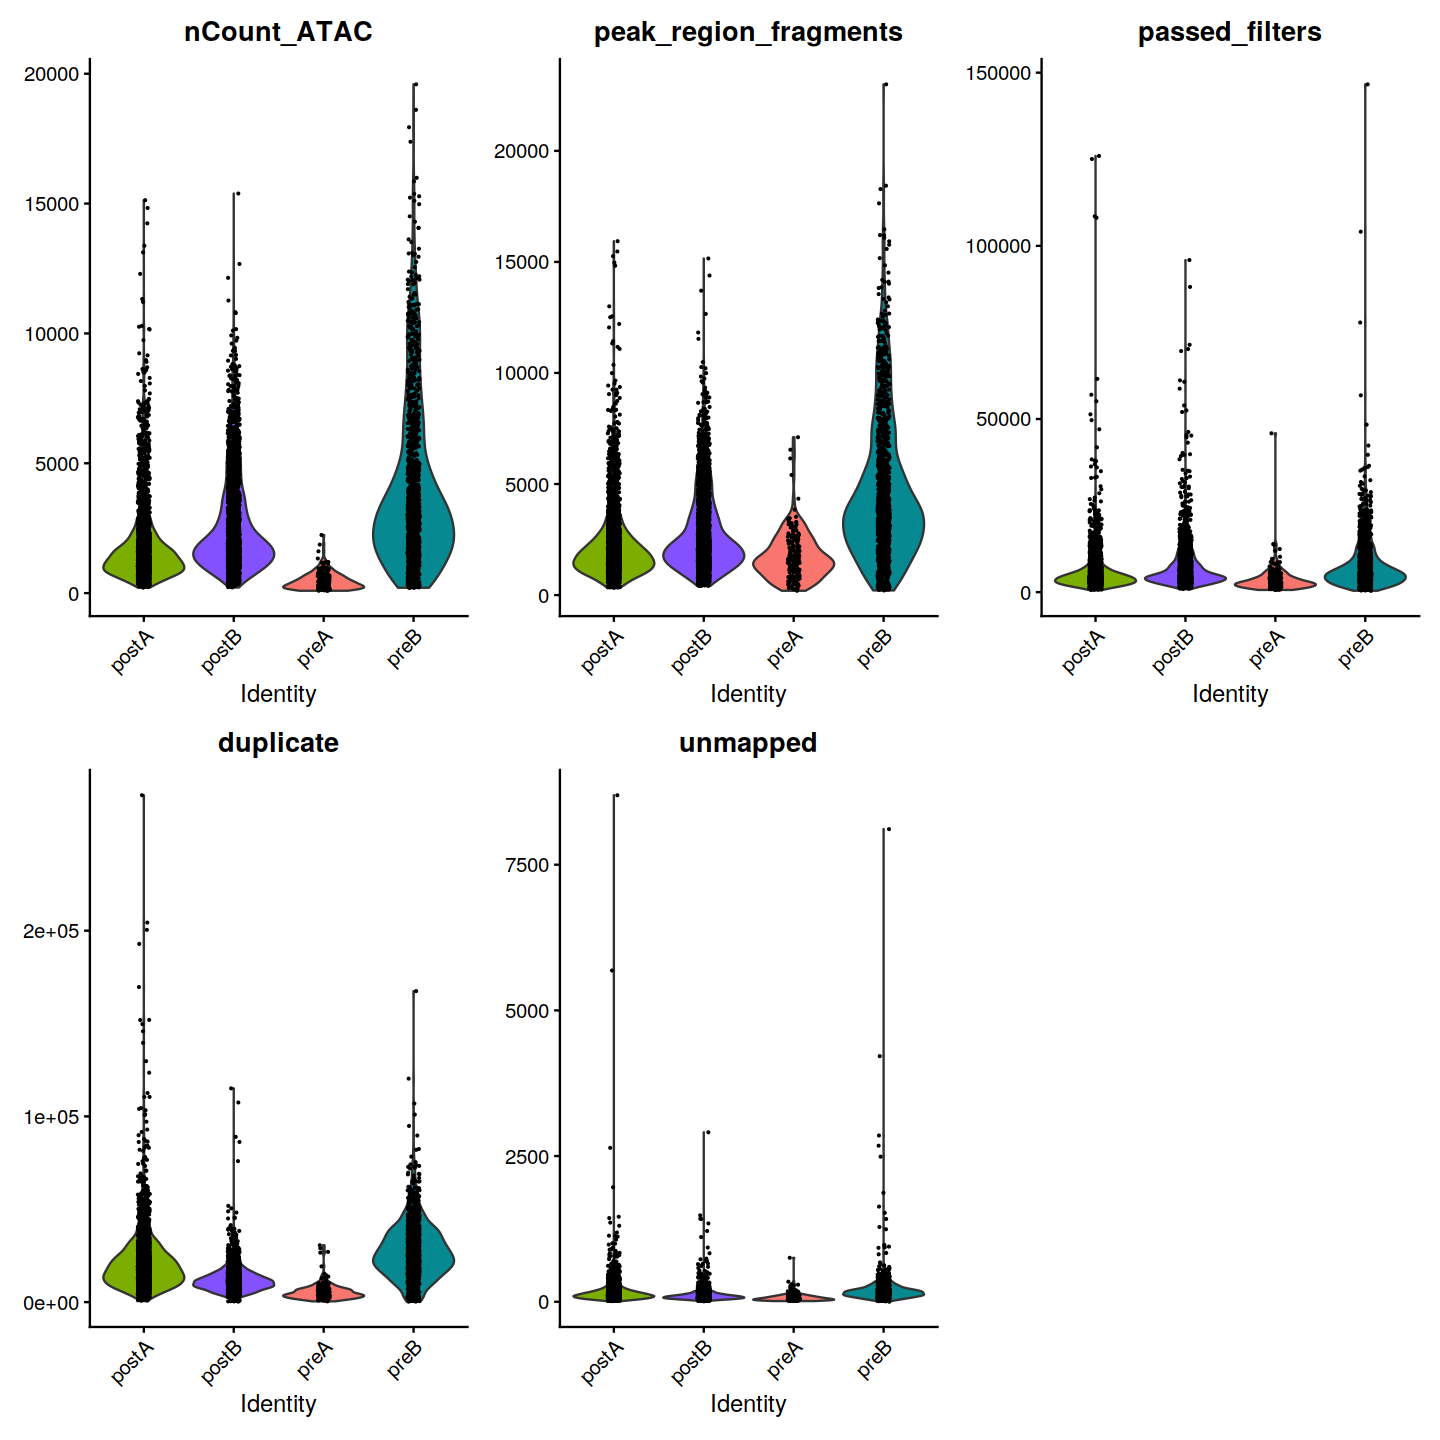

In [10]:
combined$orig.ident <- factor(combined$orig.ident, levels = sample_names)

VlnPlot(
  object = combined,
  features = c('nCount_ATAC', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  split.by = "orig.ident",
  pt.size = 0.1,
  ncol = 3
)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
22:29:18 UMAP embedding parameters a = 0.9922 b = 1.112

22:29:18 Read 7027 rows and found 49 numeric columns

22:29:18 Using Annoy for neighbor search, n_neighbors = 30

22:29:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:29:19 Writing NN index file to temp file /tmp/Rtmp1A5x1u/file86625f0db2aa

22:29:19 Searching Annoy index using 36 threads, search_k = 3000

22:29:19 Annoy recall = 100%

22:29:21 Commencing 

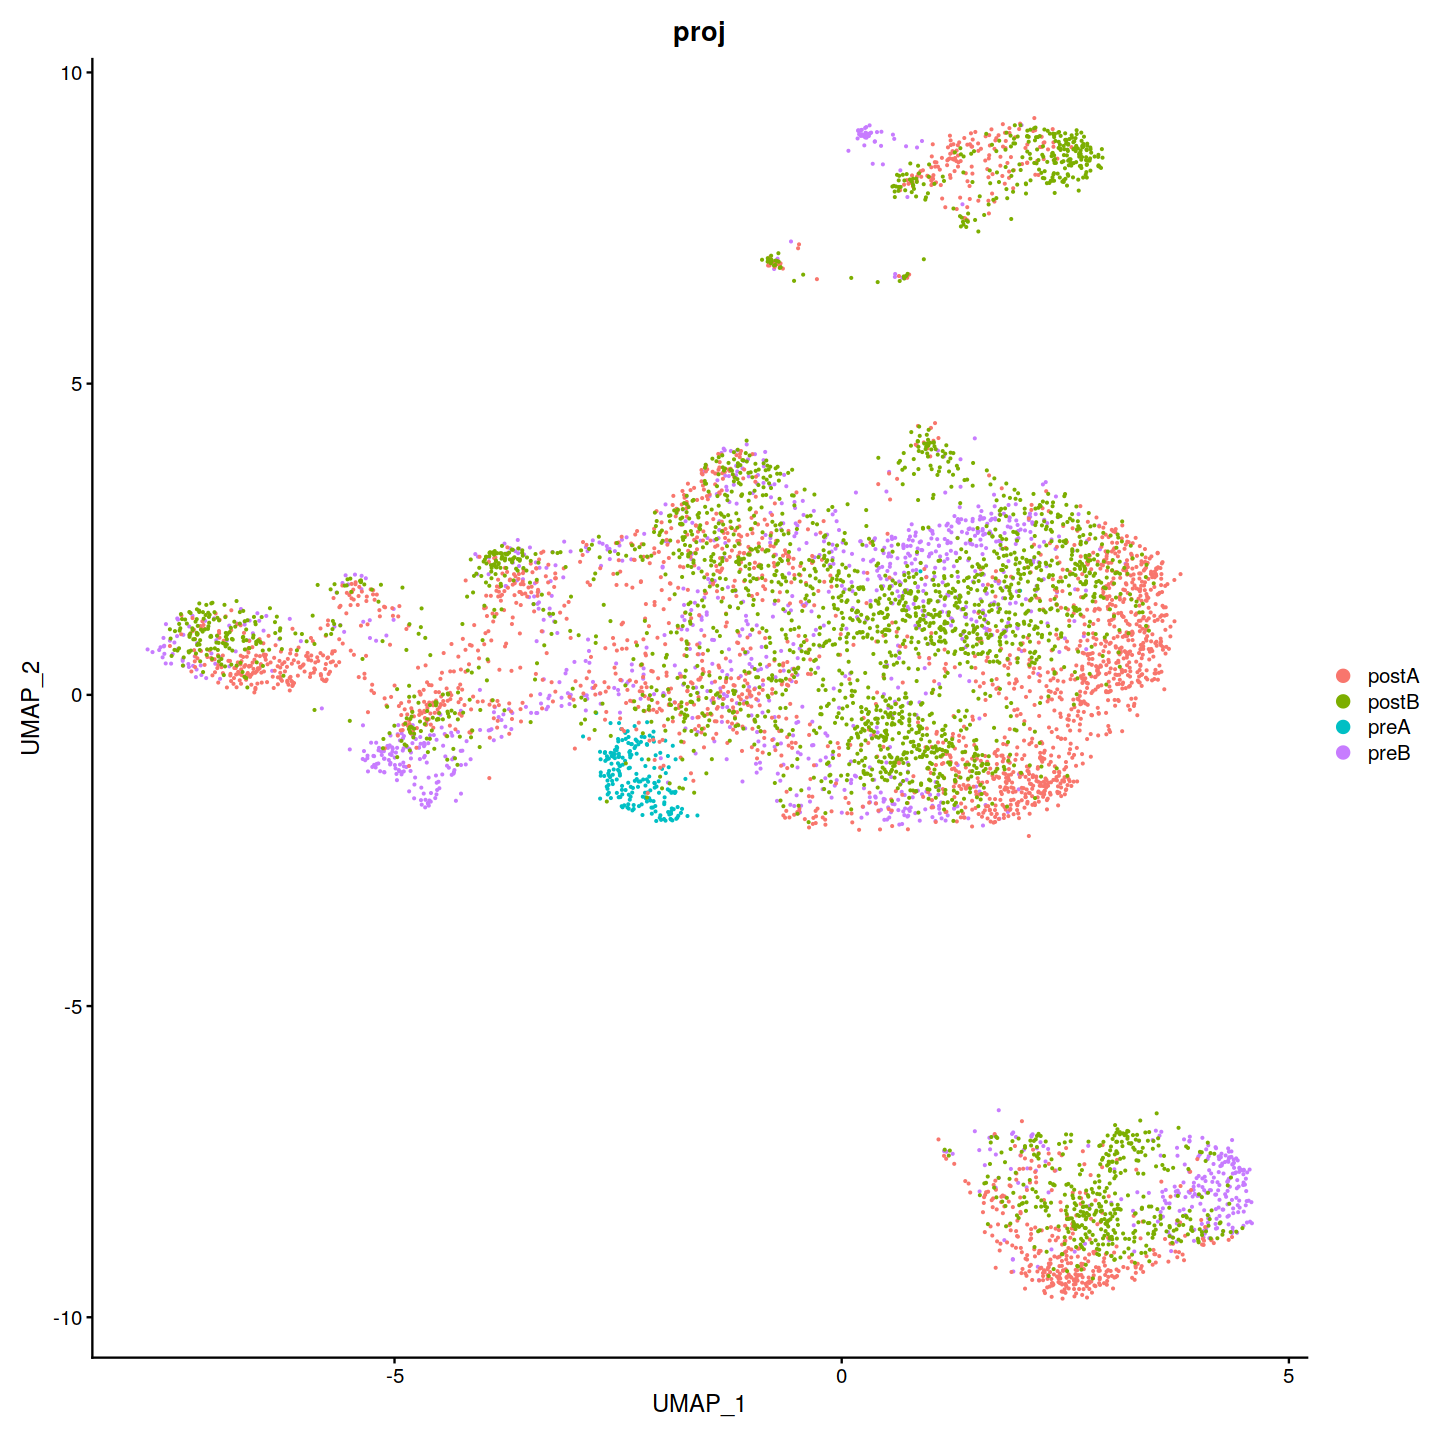

In [12]:
# Binarize and run LSI
combined <- BinarizeCounts(combined)
combined <- RunTFIDF(combined)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = 2:50, reduction = 'lsi')
DimPlot(combined, group.by = "proj", pt.size = 0.1)

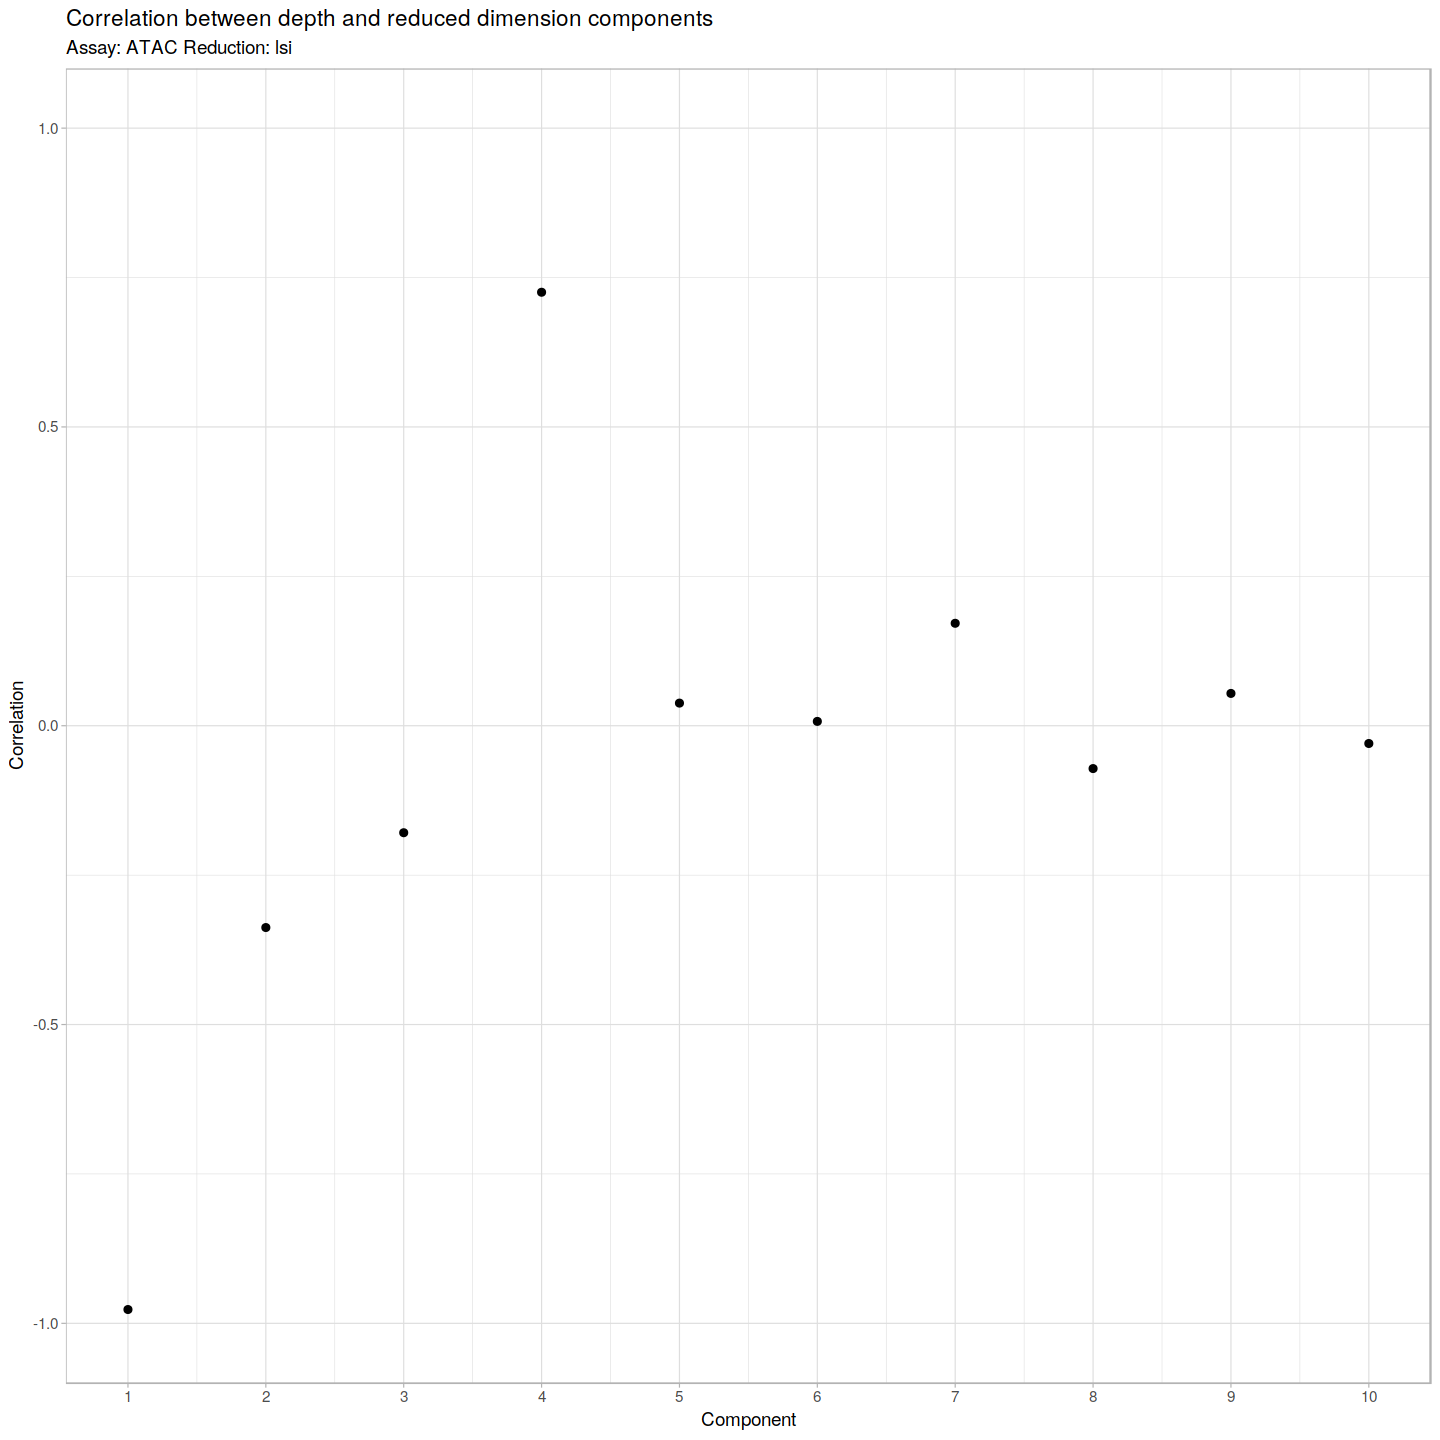

In [13]:
pDepthCorr <- DepthCor(combined)
pDepthCorr

In [16]:
saveRDS(combined, file.path(outdir, paste0("allSamples.merged.rds")))

## Integrate datasets
### Uses https://satijalab.org/signac/articles/integrate_atac.html

In [17]:
p1 <- DimPlot(combined, group.by = "proj")

## First break them up again by subsetting, then integrating

In [21]:
# ext <- subset(x = combined, subset = orig.ident == samples[1])
# curr <- subset(x = combined, subset = orig.ident == samples[2])

allSE <- lapply(sample_names,  function(x) subset(combined, subset = orig.ident == x))
allSE

[[1]]
An object of class Seurat 
46533 features across 198 samples within 1 assay 
Active assay: ATAC (46533 features, 44930 variable features)
 2 dimensional reductions calculated: lsi, umap

[[2]]
An object of class Seurat 
46533 features across 1354 samples within 1 assay 
Active assay: ATAC (46533 features, 44930 variable features)
 2 dimensional reductions calculated: lsi, umap

[[3]]
An object of class Seurat 
46533 features across 2585 samples within 1 assay 
Active assay: ATAC (46533 features, 44930 variable features)
 2 dimensional reductions calculated: lsi, umap

[[4]]
An object of class Seurat 
46533 features across 2890 samples within 1 assay 
Active assay: ATAC (46533 features, 44930 variable features)
 2 dimensional reductions calculated: lsi, umap


In [22]:
# find integration anchors
integration.anchors <- FindIntegrationAnchors(
  object.list = allSE, #c(ext,curr),
  anchor.features = allSE[[1]], #rownames(ext),
  reduction = "rlsi",
  dims = 2:30
)

# integrate LSI embeddings
integrated <- IntegrateEmbeddings(
  anchorset = integration.anchors,
  reductions = combined[["lsi"]],
  new.reduction.name = "integrated_lsi",
  dims.to.integrate = 1:30
)



Computing within dataset neighborhoods

Finding all pairwise anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 235 anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 301 anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 2818 anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 348 anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data

In [23]:
# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "proj")

00:13:09 UMAP embedding parameters a = 0.9922 b = 1.112

00:13:09 Read 7027 rows and found 29 numeric columns

00:13:09 Using Annoy for neighbor search, n_neighbors = 30

00:13:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:13:10 Writing NN index file to temp file /tmp/Rtmp1A5x1u/file866249785a1

00:13:10 Searching Annoy index using 36 threads, search_k = 3000

00:13:10 Annoy recall = 100%

00:13:11 Commencing smooth kNN distance calibration using 36 threads

00:13:13 Initializing from normalized Laplacian + noise

00:13:14 Commencing optimization for 500 epochs, with 296678 positive edges

00:13:26 Optimization finished



Saving 6.67 x 6.67 in image



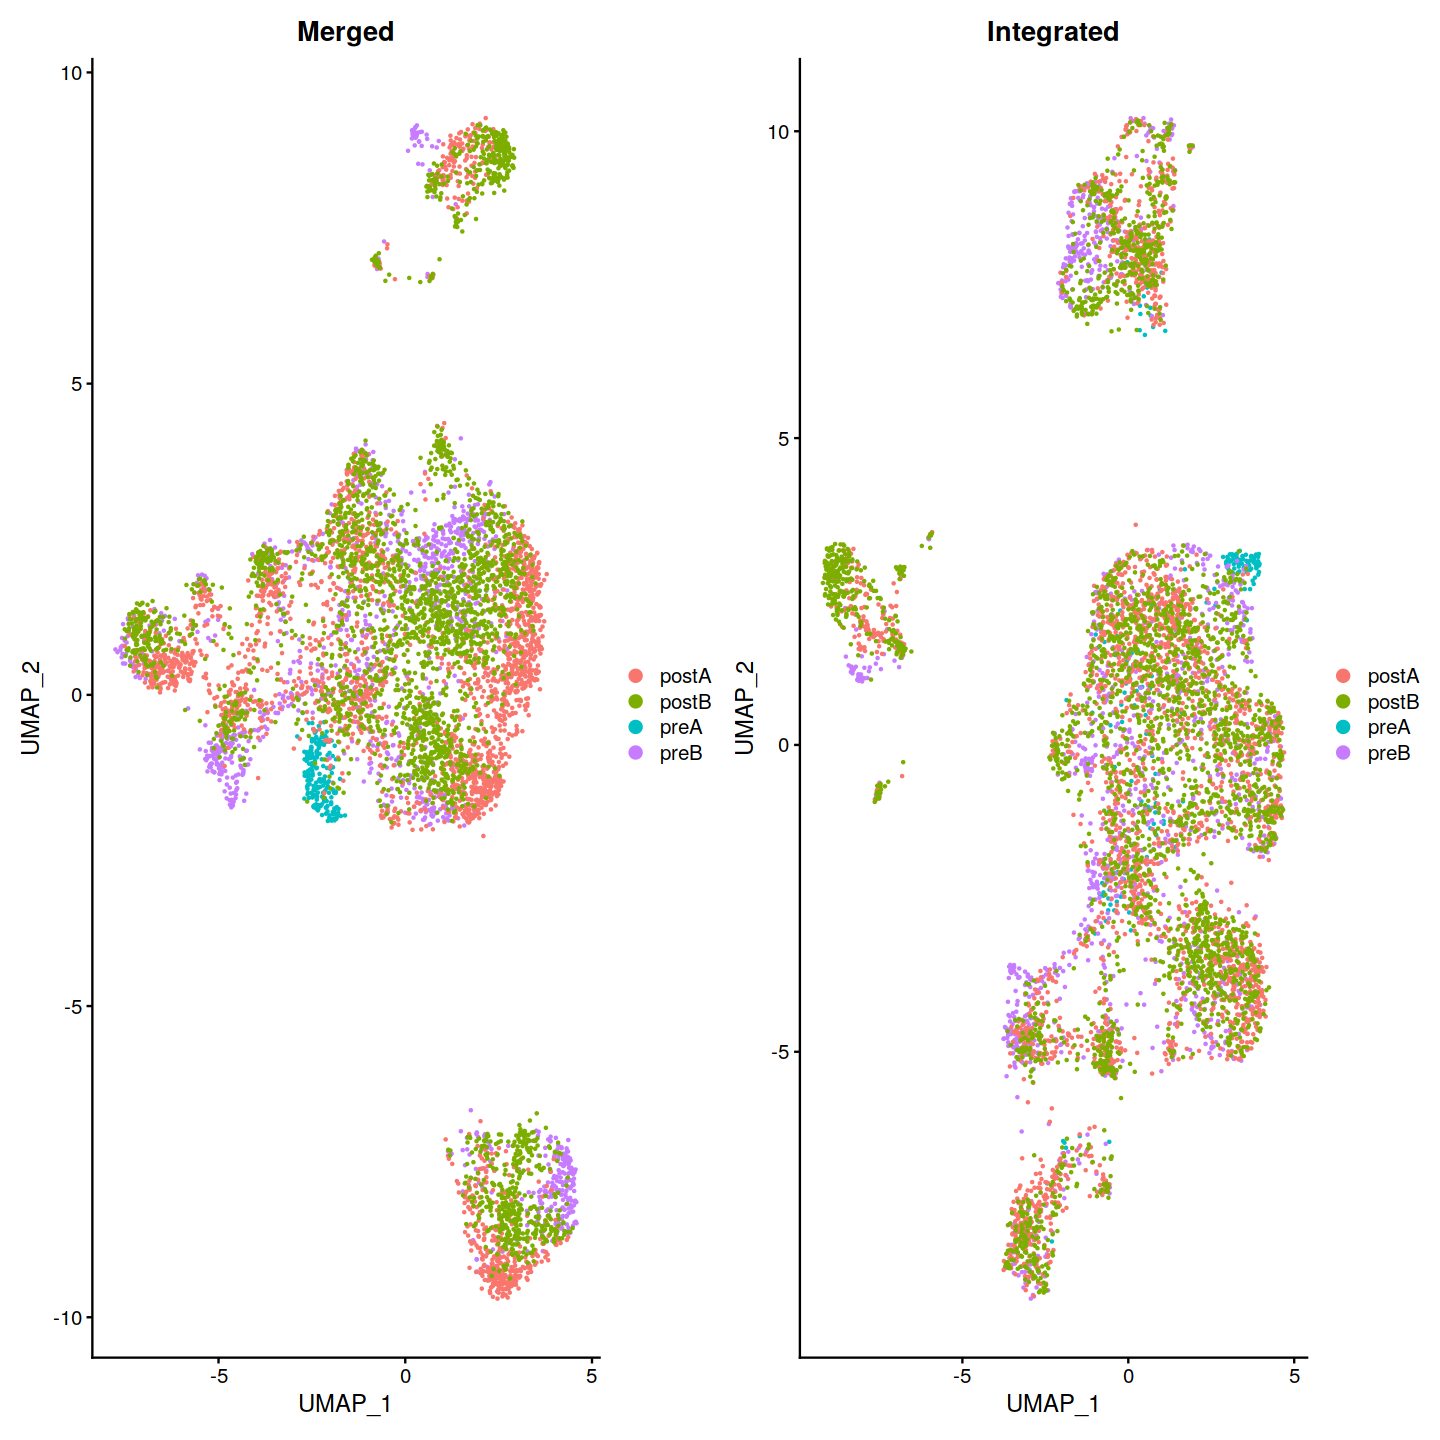

In [24]:
pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()

(p1 + ggtitle("Merged")) | (p2 + ggtitle("Integrated"))
ggsave(file.path(outdir,"integrated.merged.compare.png"))

Saving 6.67 x 6.67 in image



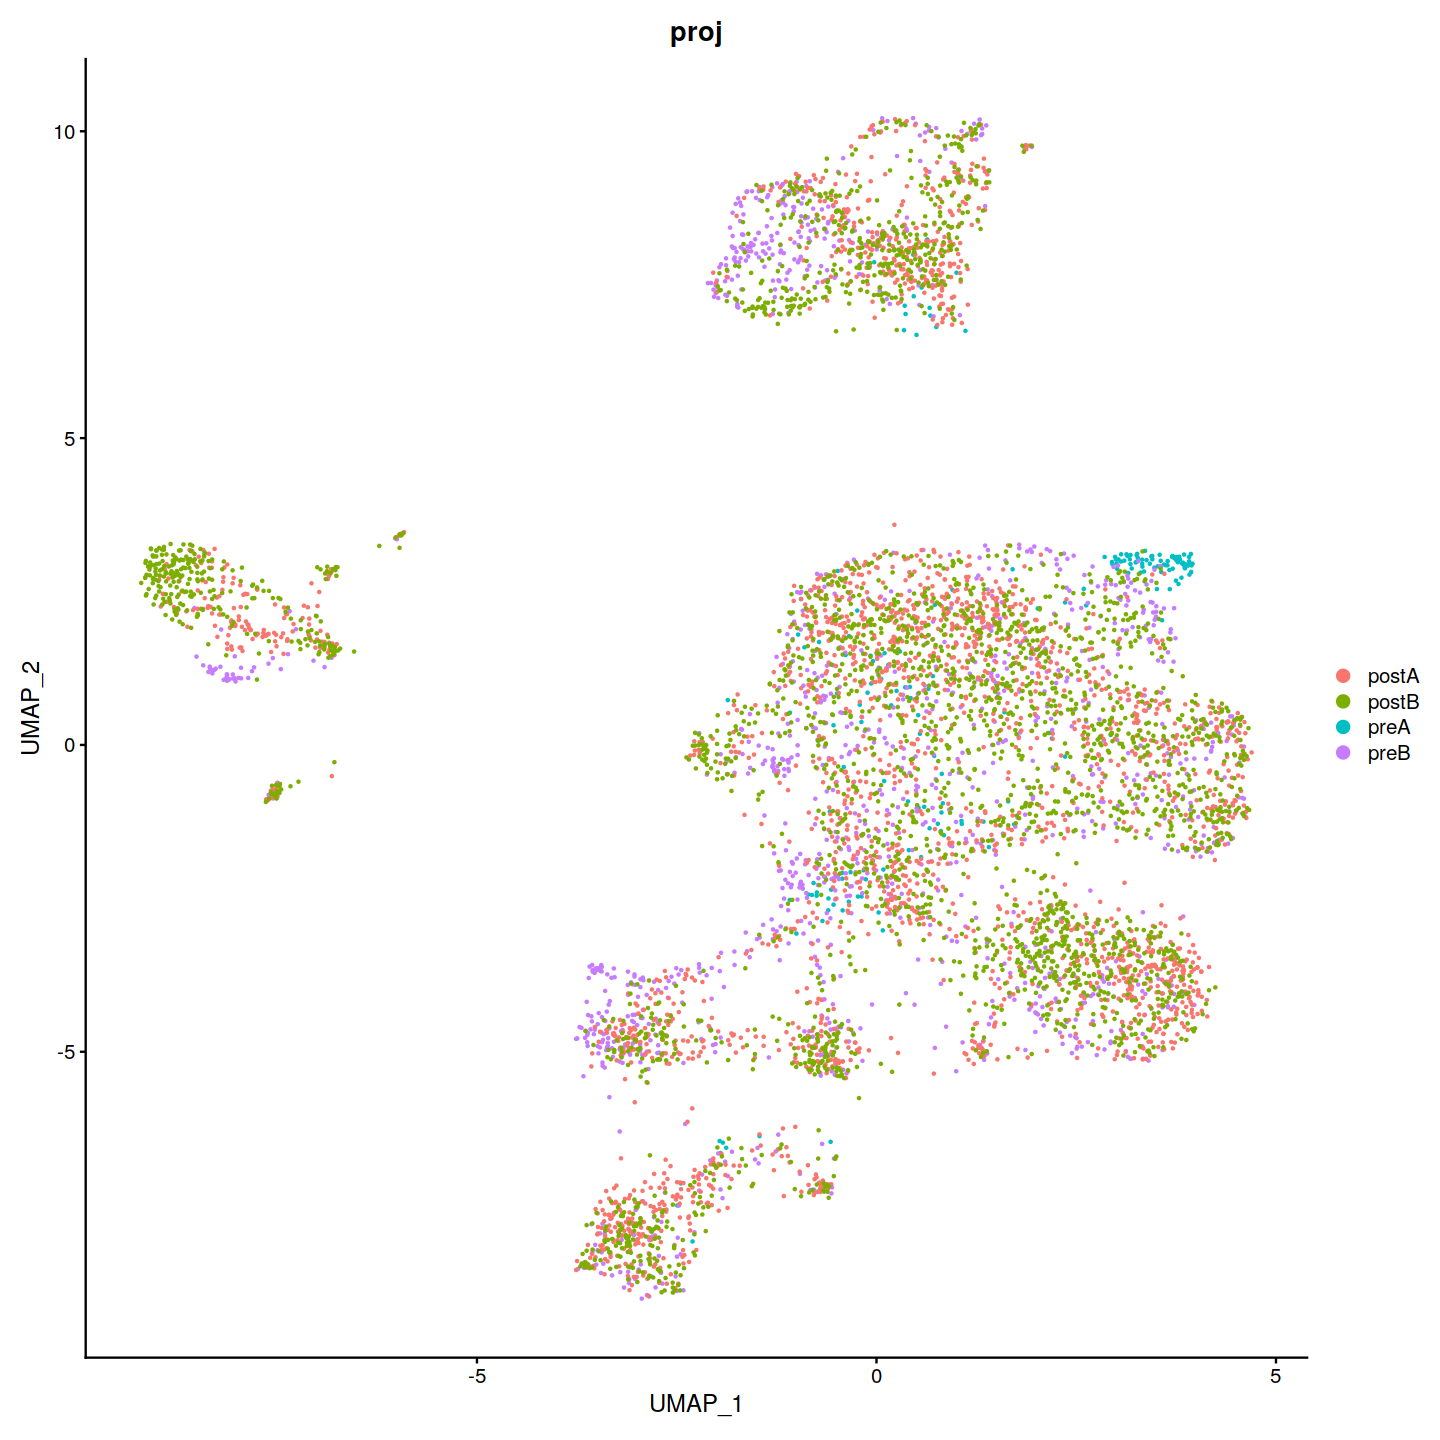

In [25]:
p2
ggsave(file.path(outdir,"integrated.batch.png"))

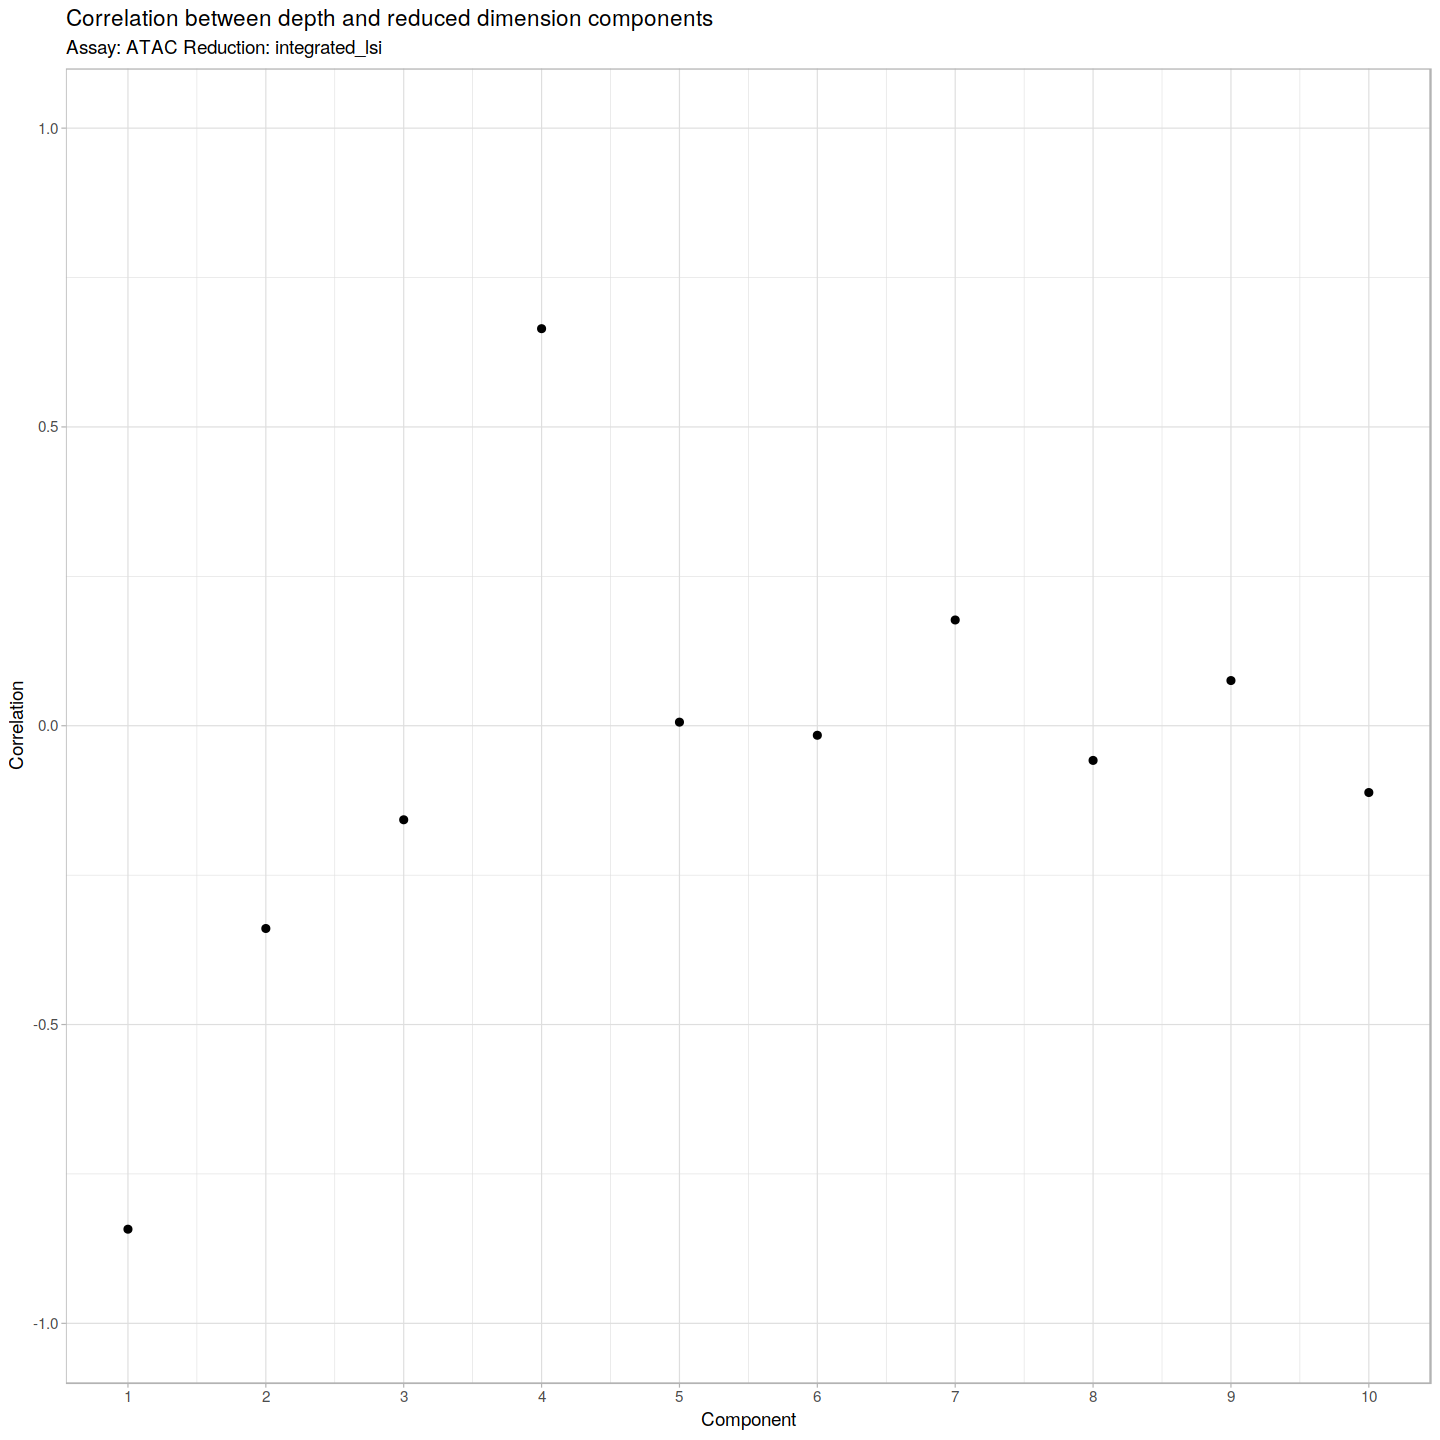

In [27]:
pDepthCorr <- DepthCor(integrated, reduction='integrated_lsi')
pDepthCorr

## Plot new cluster results

In [28]:
#integrated <- RunUMAP(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindNeighbors(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindClusters(object = integrated, verbose = FALSE, algorithm = 3)


Computing nearest neighbor graph

Computing SNN

Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."


Saving 6.67 x 6.67 in image



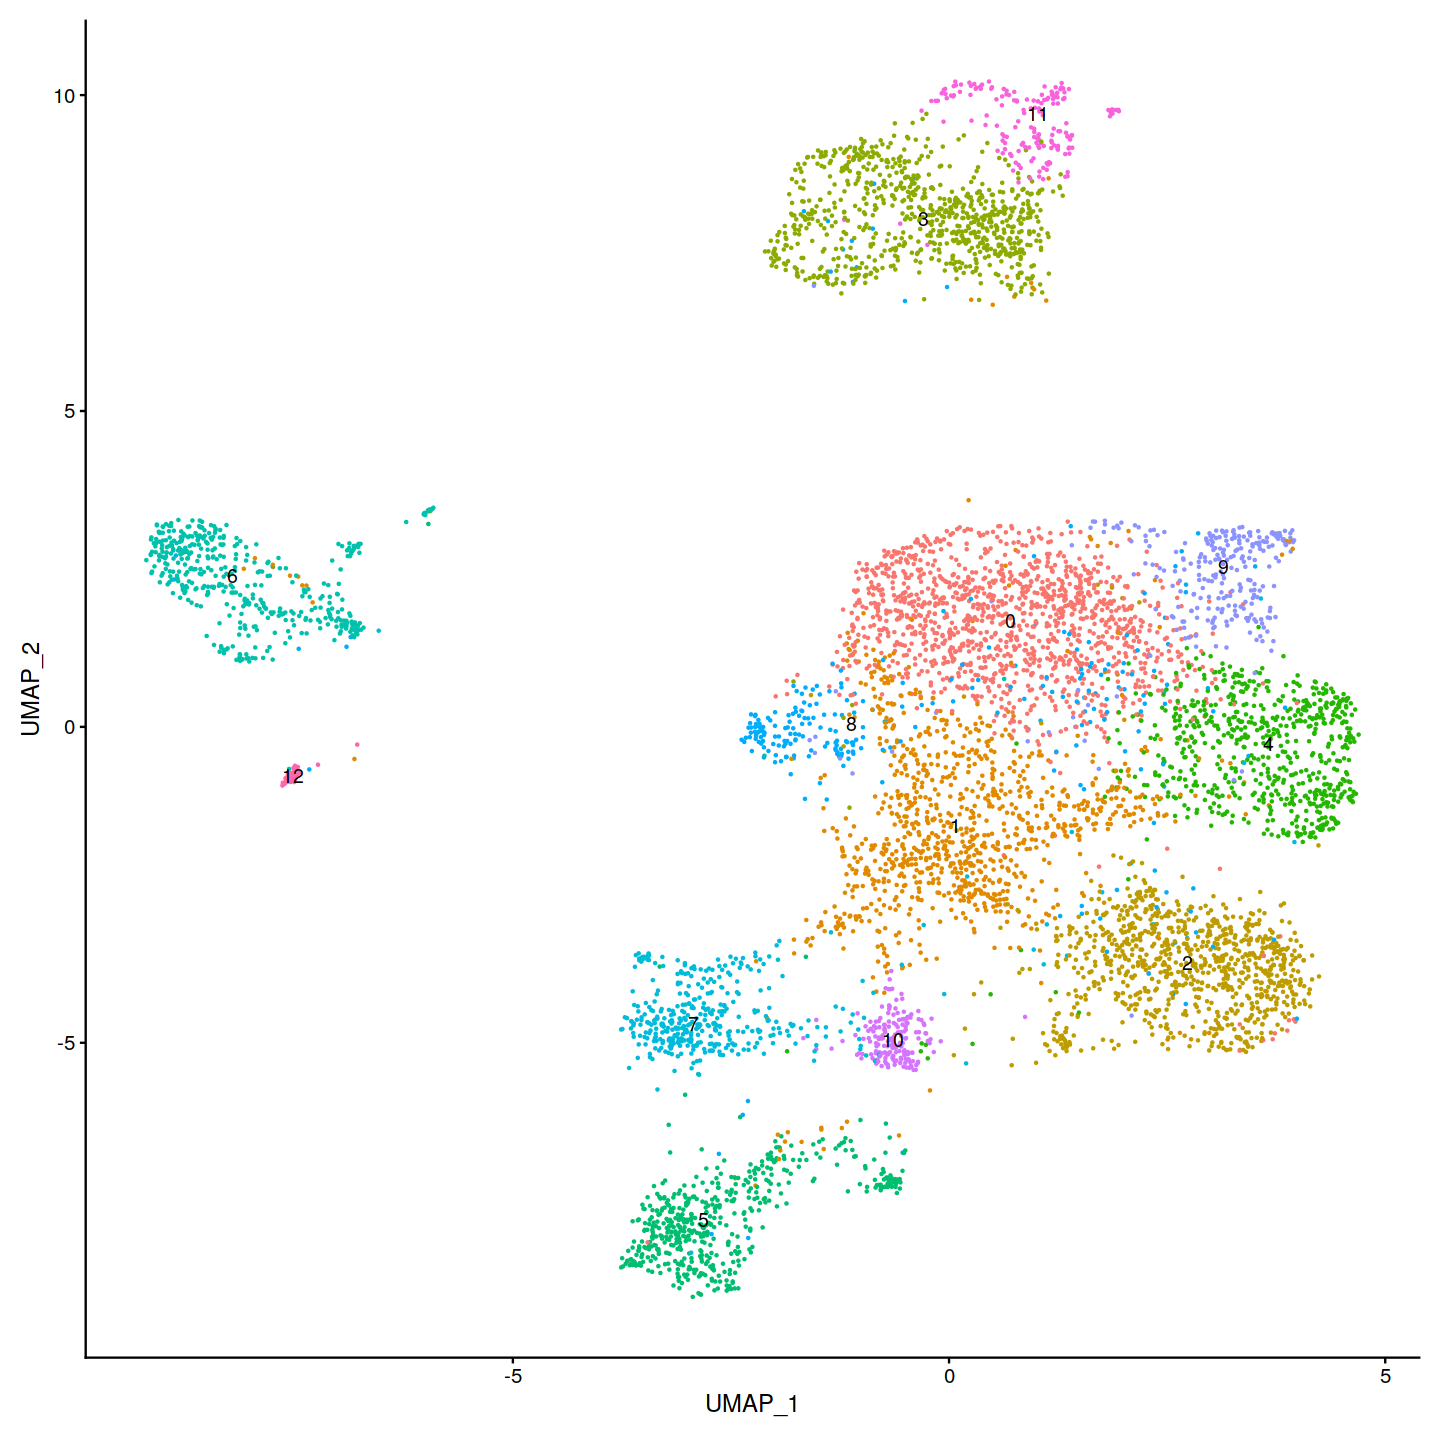

In [29]:
pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()
ggsave(file.path(outdir, "integrated.lsi.clusters.png"), pclust)
pclust

In [ ]:
## ATAC DE peaks

# # change back to working with peaks instead of gene activities
# DefaultAssay(integrated) <- 'ATAC'

# da_peaks <- FindMarkers(
#   object = integrated,
#   ident.1 = 9, #"CD4 Naive",
#   min.pct = 0.05,
#   test.use = 'LR',
#   #latent.vars = 'peak_region_fragments'
# )


# plot1 <- VlnPlot(
#   object = integrated,
#   features = rownames(da_peaks)[1],
#   pt.size = 0.1,
#   idents = c(1,9)
# )
# plot2 <- FeaturePlot(
#   object = integrated,
#   features = rownames(da_peaks)[1],
#   pt.size = 0.1
# )

# plot1 | plot2


## Get gene activity results and run DE results for RNA

In [32]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# change to UCSC style since the data was mapped to hg19
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"

# add the gene information to the object
Annotation(integrated) <- annotations


gene.activities <- GeneActivity(integrated)


Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

In [33]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
integrated[['RNA']] <- CreateAssayObject(counts = gene.activities)
integrated <- NormalizeData(
  object = integrated,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(integrated$nCount_RNA)
)

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"


In [34]:
DefaultAssay(integrated) <- 'RNA'

In [36]:
saveRDS(integrated, file.path(outdir, paste0("allSamples.integrated.rds")))

In [37]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/isshamie/software/anaconda3/envs/mito_trace/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] future_1.22.1             dplyr_1.0.7              
 [3] metap_1.4                 cowplot_1.1.1            
 [5] magrittr_2.0.1            data.table_1.14.0        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 en

In [ ]:
# ## Compute DE for each cluster

# plotDE <- function(integrated, de.results, i, outdir){
#     try
#     {
#     plot1 <- VlnPlot(
#       object = integrated,
#       features = rownames(de.results)[1],
#       pt.size = 0.1,
#       idents = i
#     )
#     plot2 <- FeaturePlot(
#       object = integrated,
#       features = rownames(de.results)[1],
#       pt.size = 0.1
#     )

#     plot3 <- FeaturePlot(
#       object = integrated,
#       features = rownames(de.results)[2],
#       pt.size = 0.1
#     )
    
#     plot1 | plot2 | plot3
    
#     ggsave(file.path(outdir,paste0("cluster_",i,".DE.GeneActivity.top2Genes.png")))
    
#     return(c(plot1, plot2, plot3))
#     }
#     return
# }

# ## Loop through each cluster and run DA for RNA-seq

# cluster.ids <- sort(unique(Idents(integrated)))

# de.results <- function(i){
#     print(paste("cluster", i))
#     da.peaks <- FindMarkers(
#                   object = integrated,
#                   ident.1 = i, #"CD4 Naive",
#                   min.pct = 0.1,
#                   test.use = 'LR',
#                 )
#     colnames(da.peaks) <- lapply(colnames(da.peaks), function(x) paste0("cluster", i, "__", x))
#     da.peaks$gene = rownames(da.peaks)
#     #write.csv(da.peaks, file=file.path(outdir,paste0("cluster_",i,".DE.GeneActivity.csv")))
#     #print(paste('saved cluster', x))
#     #p_out <- plotDE(integrated, da.peaks, x, outdir)
#     #all.plotDE <- c(all.plotDE, p_out)
#     #print(paste('plotted cluster', x))    
#     return(da.peaks)
# }
                                 
# all.da <- lapply(cluster.ids, function(x) de.results(x))
# all.da <- plyr::join_all(all.da, by="gene")
# write.csv(all.da, file=file.path(outdir,"allCluster.DE.GeneActivity.csv"))

# # cluster.ids <- sort(unique(Idents(integrated)))

# # all.da = data.frame(rownames=rownames(integrated))
# # all.plotDE = c()
# # for (i in cluster.ids){ #or however many clusters you have
# # try({
# #     print(paste("cluster", i))
# #     da.peaks <- FindMarkers(
# #                   object = integrated,
# #                   ident.1 = i, #"CD4 Naive",
# #                   min.pct = 0.1,
# #                   test.use = 'LR',
# #                 )
# #     colnames(da.peaks) <- lapply(colnames(da.peaks), function(x) paste0("cluster", i, "__", x))
# #     all.da = full_join(all.da, da.peaks)
# #     #write.csv(da.peaks, file=file.path(outdir,paste0("cluster_",i,".DE.GeneActivity.csv")))
# #     print(paste('saved cluster', i))

# #     p_out <- plotDE(integrated, da.peaks, i, outdir)
# #     all.plotDE <- c(all.plotDE, p_out)
# #     print(paste('plotted cluster', i))
    
# # })
# # }

# ## Dotplots for clusters

# ### First feature plots

# ### Immune markers taken from Seurat

# FeaturePlot(integrated, features = c("CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", 
#     "CCL2", "PPBP"), min.cutoff = "q9")
# ggsave(file.path(outdir,"lin.ImmuneGenes.umap.png"))

# markers.to.plot <- c("CD3D", "CREM", "HSPH1", "SELL", "GIMAP5", "CACYBP", "GNLY", "NKG7", "CCL5", 
#     "CD8A", "MS4A1", "CD79A", "MIR155HG", "NME1", "FCGR3A", "VMO1", "CCL2", "S100A9", "HLA-DQA1", 
#     "GPR183", "PPBP", "GNG11", "HBA2", "HBB", "TSPAN13", "IL3RA", "IGJ")
# DotPlot(integrated, features = rev(markers.to.plot), cols = c("blue", "red"), dot.scale = 8, 
#     split.by = "orig.ident") + RotatedAxis()

# ggsave(file.path(outdir,"lin.ImmuneGenes.dot.png"))

# ### Immune markers taken from Dawn Lin et al Flt3l paper

# immune.markers = c('KIT',
#                    'LY6E',
#                    'ITGAX',
#                    'SLAMF1',
#                    'CD34',
#                    'FCGR3A',
#                    'PTPRC',
#                    'SLAMF2',
#                    'IL7R',
#                    'ITGAM')

# DotPlot(integrated, features = rev(immune.markers), cols = c("blue", "red"), dot.scale = 8, 
#     split.by = "orig.ident") + RotatedAxis()
# ggsave(file.path(outdir,"seurat.ImmuneGenes.dot.png"))

# FeaturePlot(integrated, features = immune.markers, min.cutoff = "q9")

## Conserved markers to help idenify cell type

In [ ]:
# cluster.ids <- sort(unique(Idents(integrated)))
# topMarkers = c()
# for (i in cluster.ids){ #or however many clusters you have
# try({
#     print(paste("cluster", i))
#     cons.markers <- FindConservedMarkers(integrated, ident.1 = i, 
#                                          grouping.var = "orig.ident", verbose = TRUE)

#     write.csv(cons.markers, file=file.path(outdir,paste0("cluster_",i,".conservedOverStim.GeneActivity.csv")))
#     print(paste('saved cluster', i))
#     print(head(cons.markers))
#     topMarkers = c(topMarkers, rownames(cons.markers)[1])
#     print(topMarkers)
# })
# }

# head(cons.markers)

In [ ]:
# theme_set(theme_cowplot())
# t.cells <- subset(integrated, idents = 9)#"CD4 Naive T")
# Idents(t.cells) <- "orig.ident"
# avg.t.cells <- data.frame(log1p(AverageExpression(t.cells, verbose = FALSE)$RNA))
# rownames(avg.t.cells) <- rownames(t.cells) #avg.t.cells$gene <- rownames(avg.t.cells)

# cd14.mono <- subset(integrated, idents = 2)
# Idents(cd14.mono) <- "orig.ident"
# avg.cd14.mono <- data.frame(log1p(AverageExpression(cd14.mono, verbose = FALSE)$RNA))
# rownames(avg.cd14.mono) <- rownames(cd14.mono) #$gene <- rownames(avg.cd14.mono)

In [ ]:
# genes.to.label = c("ISG15", "LY6E", "IFI6", "ISG20", "MX1", "IFIT2", "IFIT1", "CXCL10", "CCL8")
# p1 <- ggplot(avg.t.cells, aes_string(samples[[1]], samples[[2]])) + geom_point() + ggtitle("Cluster 9")
# p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE, xnudge=0, ynudge=0)
# p2 <- ggplot(avg.cd14.mono, aes_string(samples[[1]], samples[[2]])) + geom_point() + ggtitle("Cluster 2")
# p2 <- LabelPoints(plot = p2, points = genes.to.label, repel = TRUE)
# plot_grid(p1, p2)